# Big Data Analytics for Scanning Transmission Electron Microscopy Ptychography

**S. Jesse, M. Chi, A. Belianinov, C. Beekman, S. V. Kalinin, A. Y. Borisevich & A. R. Lupini**

Supporting material for paper published in:<br>
**Scientific Reports** -  https://www.nature.com/articles/srep26348

Notebook written by:<br>
**Suhas Somnath, and Chris R. Smith**<br>
The Center for Nanophase Materials Science and The Institute for Functional Imaging for Materials <br>
Oak Ridge National Laboratory<br>
1/19/2017

pyUSID version: 0.0.4
pycroscopy version: 0.60.1

**Note: This notebook was written for the pyUSID and pycroscopy versions listed above and is not guaranteed to work on past or future versions of the packages**

Here, we will be working with four dimensional datasets acquired using a scanning transmission electron microscope (STEM). These datsets have four dimensions - two (x, y) dimensions from the position of the electron beam and each spatial pixel contains a two dimensional (u, v) image, called a **ronchigram**, recorded by the detector. Though the ronchigrams are typically averaged to two values (bright field, dark field), retaining the raw ronchigrams enables deeper investigation of data to reveal the existence of different phases in the material and other patterns that would typically not be visible in the averaged data

![notebook_rules.png](../../notebook_rules.png)

Image courtesy of Jean Bilheux from the [neutron imaging](https://github.com/neutronimaging/python_notebooks) GitHub repository.

## Configure the notebook first

In [1]:
# Make sure needed packages are installed and up-to-date
import sys
#!conda install --yes --prefix {sys.prefix} numpy scipy matplotlib scikit-learn Ipython ipywidgets h5py
#!{sys.executable} -m pip install -U --no-deps pyUSID==0.0.4
#!{sys.executable} -m pip install -U --no-deps pycroscopy==0.60.2

In [2]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

import os

# Import necessary libraries:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import display, HTML
import ipywidgets as widgets
from sklearn.cluster import KMeans

sys.path.append('..')
import pyUSID as usid
import pycroscopy as px

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, FastICA
import subprocess

# Make Notebook take up most of page width
display(HTML(data="""
    <style>
    div#notebook-container    { width: 80%; }
    div#menubar-container     { width: 80%; }
    div#maintoolbar-container { width: 80%; }
    </style>"""))



C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pycroscopy\__init__.py:31: FutureWarning: Contents of pycroscopy.core such as hdf_utils, plot_utils have been moved to pyUSID but will continue to be available implicitly till the next release. Please update import statements to import such modules directly frompyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018
  'pyUSID. See - https://pycroscopy.github.io/pycroscopy/whats_new.html under June 28 2018', FutureWarning)


In [3]:
# set up notebook to show non-interactive plots within the notebook
% matplotlib notebook 
#############################################################

## Load pycroscopy compatible 4D STEM dataset

For simplicity we will use a dataset that has already been translated form its original data format into a **Univeral Spectroscopy and Imaging Data (USID)** hierarchical data format (HDF5 or H5) file. For more information regarding USID, HDF5, etc. please see the documentation on our github projects

In [4]:
# Select a file to work on:
#h5_path = r'../Data/4D STEM 20120212_21_GBb.h5'#
h5_path = usid.io_utils.file_dialog('*.h5', '4D STEM dataset formatted according to USID')
print('Working on:\n' + h5_path)
# Open the file
h5_file = h5py.File(h5_path, mode='r+')

Working on:
C:/Users/sjz/Desktop/CNMS user meeting tutorial 2018/data/4D STEM 20120212_21_GBb.h5


## Get reference to Raw measurement

In [5]:
# Select the dataset containing the raw data to start working with:
h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')

h5_main = usid.USIDataset(h5_main)

# Read some necessary parameters:
h5_pos_inds = h5_main.h5_pos_inds
num_rows, num_cols = h5_main.pos_dim_sizes
h5_spec_inds = h5_main.h5_spec_inds
num_sensor_rows, num_sensor_cols = h5_main.spec_dim_sizes

C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


## Visualize the Raw Ronchigrams

<IPython.core.display.Javascript object>


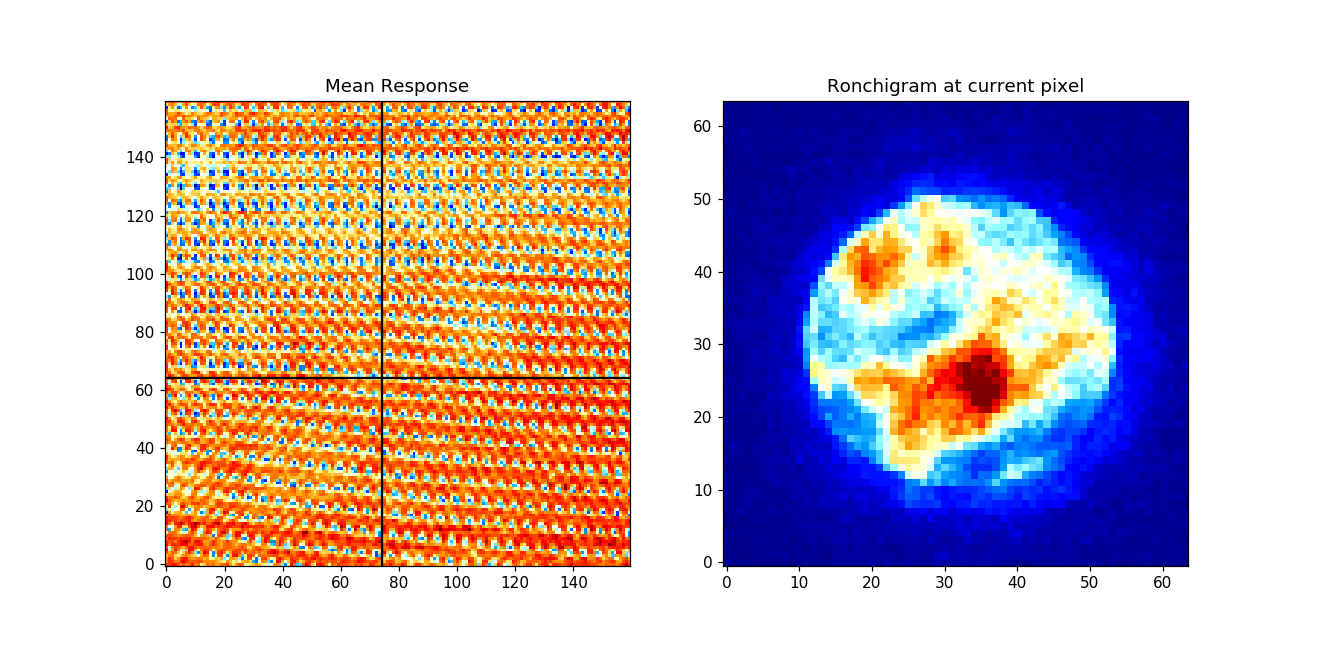

C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  


In [6]:
coarse_row = int(0.5*num_rows)
coarse_col = int(0.5*num_cols)
coarse_pos = coarse_row * num_rows + coarse_col

current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

fig, axes = plt.subplots(ncols=2, figsize=(12,6))
axes[0].hold(True)
axes[0].set_title('Mean Response')
main_map = axes[0].imshow(np.reshape(h5_main.parent['Spectroscopic_Mean'], (num_rows, num_cols)), 
                          cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')
main_vert_line = axes[0].axvline(x=coarse_col, color='k')
main_hor_line = axes[0].axhline(y=coarse_row, color='k')
axes[1].set_title('Ronchigram at current pixel')
img_zoom = axes[1].imshow(current_ronch,cmap=px.plot_utils.cmap_jet_white_center(), origin='lower')

def move_zoom_box(event):
    if not main_map.axes.in_axes(event):
        return
    
    coarse_col = int(round(event.xdata))
    coarse_row = int(round(event.ydata))
    main_vert_line.set_xdata(coarse_col)
    main_hor_line.set_ydata(coarse_row)
    
    coarse_pos = coarse_row * num_rows + coarse_col
    current_ronch = np.reshape(h5_main[coarse_pos], (num_sensor_rows, num_sensor_cols))

    img_zoom.set_data(current_ronch)
    #img_zoom.set_clim(vmax=ronch_max, vmin=ronch_min)
    fig.canvas.draw()
    

cid = main_map.figure.canvas.mpl_connect('button_press_event', move_zoom_box)
#widgets.interact(move_zoom_box, coarse_row=(0, num_rows, 1), coarse_col=(0, num_cols, 1));

## Performing Singular Value Decompostion (SVD)
SVD decomposes data (arranged as position x value) into a sequence of orthogonal components arranged in descending order of variance. The first component contains the most significant trend in the data. The second component contains the next most significant trend orthogonal to all previous components (just the first component). Each component consists of the trend itself (eigenvector), the spatial variaion of this trend (eigenvalues), and the variance (statistical importance) of the component.

Here, SVD essentially compares every single ronchigram with every other ronchigram to find statistically significant trends in the dataset. Such correlation would be infeasible if the ronchigrams were averaged to bright-field and dark-field scalar values. 

In [7]:
# Choose how many components you want
num_svd_comps = 256

proc = px.processing.SVD(h5_main, num_components=num_svd_comps)

h5_svd_group = proc.compute() ########################################################################
    
h5_u = h5_svd_group['U']
h5_v = h5_svd_group['V']
h5_s = h5_svd_group['S']

C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: SVD has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_000" (8 members)>, <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_001" (8 members)>, <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_002" (8 members)>, <HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_004" (13 members)>]
Note: SVD has already been performed PARTIALLY with the same parameters. compute() will resuming computation in the last group below. To choose a different group call use_patial_computation()Set override to True to force fresh computation or resume from a data group besides the last in the list.
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_003" (8 members)>]
Returning previously

In [8]:
h5_grp = h5_file['/Measurement_000/Channel_000/Raw_Data-SVD_001']
usid.hdf_utils.get_attributes(h5_grp)

{'machine_id': 'PC102002.ornl.gov',
 'timestamp': '2018_08_03-11_39_04',
 'pyUSID_version': '0.0.4',
 'platform': 'Windows-7-6.1.7601-SP1',
 'tool': 'SVD',
 'num_source_dsets': 1,
 'source_000': <HDF5 object reference>,
 'num_components': 256,
 'svd_method': 'sklearn-randomized',
 'last_pixel': 25600}

## Visualize the SVD results

##### S (variance):
The plot below shows the variance or statistical significance of the SVD components. The first few components contain the most significant information while the last few components mainly contain noise. 

Note also that the plot below is a log-log plot. The importance of each subsequent component drops exponentially.

<IPython.core.display.Javascript object>


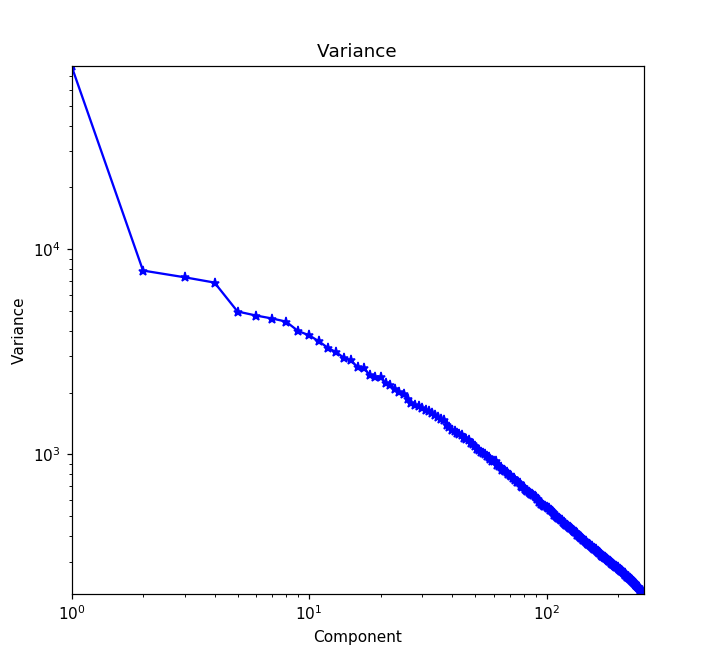

In [9]:
# Visualize variance of the principal components
fig, axes = usid.plot_utils.plot_scree(h5_s, title='Variance')

#### U (Eigenvalues or Abundance maps):
The plot below shows the spatial distribution of each SVD component

<IPython.core.display.Javascript object>


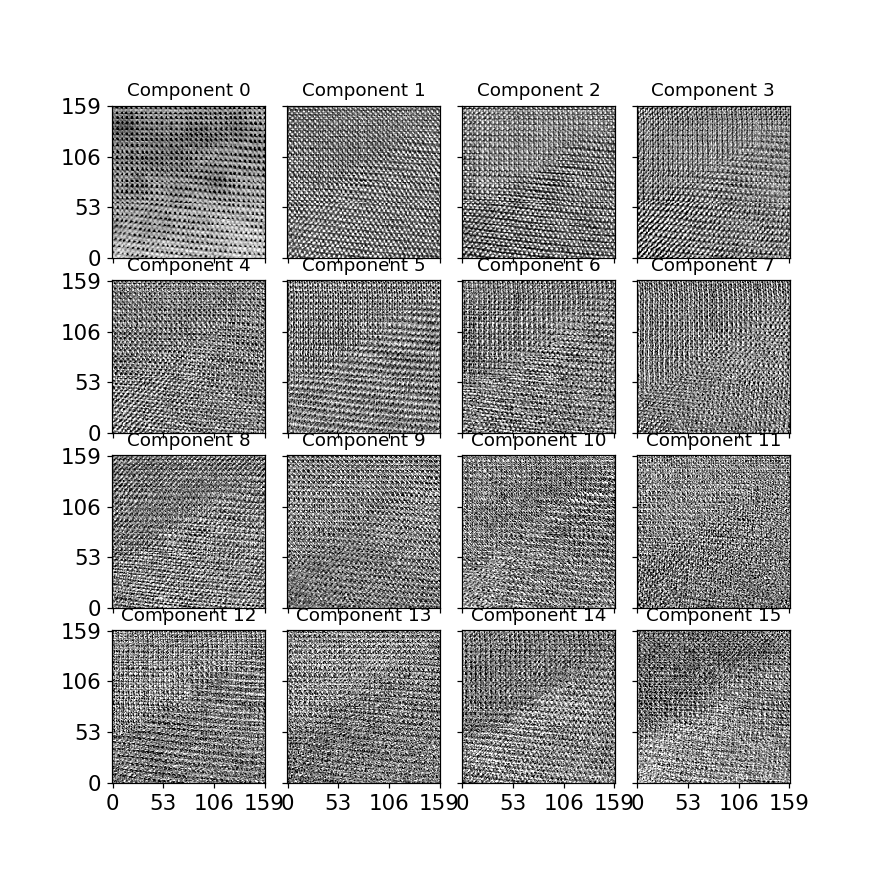

In [10]:
# Choose how many components of U and V to display
num_plot_comps = 16
# Visualize the abundance maps from SVD:
loadings = np.reshape(h5_u[:, :num_plot_comps], (num_rows, num_cols, -1)).transpose([2, 0, 1])
#fig, axes = usid.plot_utils.plot_map_stack(loadings, num_comps=num_plot_comps, title=None,pad_mult=(0.1, 0.1),
#                                         cmap=px.plot_utils.cmap_jet_white_center(), fig_mult=(3,3))
fig, axes = usid.plot_utils.plot_map_stack(loadings, num_comps=num_plot_comps, title=None,pad_mult=(0.1, 0.1), fig_mult=(2,2),
                                         cmap=plt.cm.gray)

#### V (Endmembers or Eigenvectors)
The V dataset contains the endmembers for each component

<IPython.core.display.Javascript object>


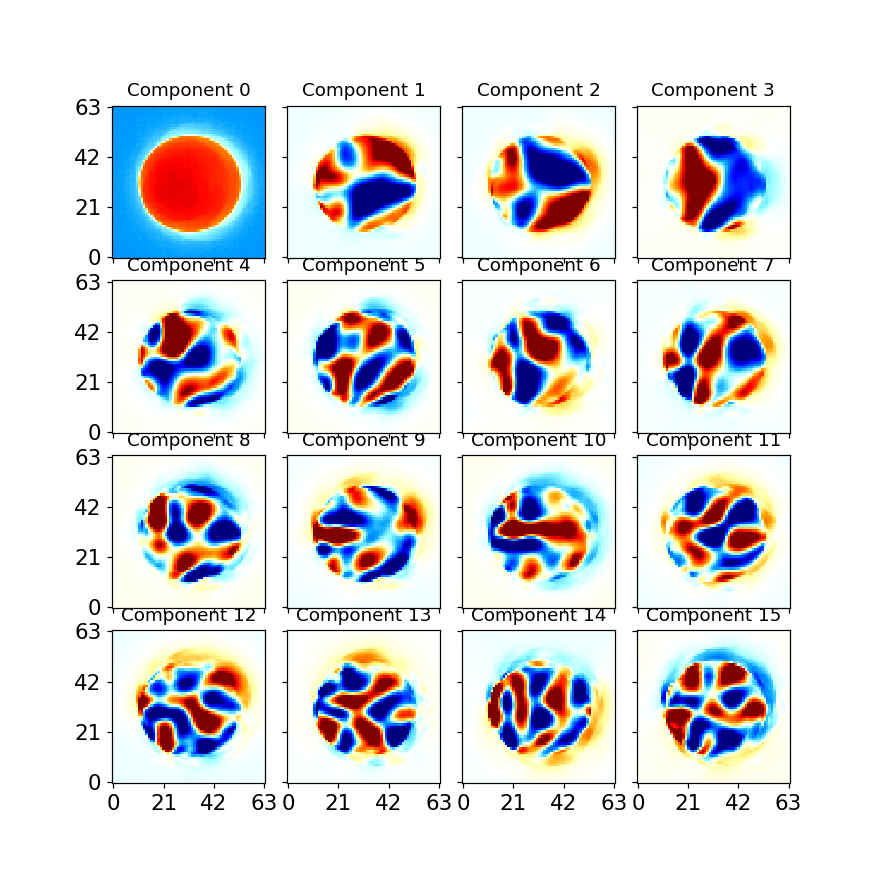

In [11]:
# Visualize the Endmembers from SVD:
eigenvectors = np.reshape(h5_v[:num_plot_comps], (-1, num_sensor_rows, num_sensor_cols))
fig, axes = usid.plot_utils.plot_map_stack(eigenvectors, num_comps=num_plot_comps, title=None,pad_mult=(0.1, 0.1), fig_mult=(2,2),
                                         cmap=px.plot_utils.cmap_jet_white_center())

# Non-negative Matrix Factorization

NMF is a decomposition of a matrix X into two smaller matrices (W,H), with the stipulation that all matrices are non-negative (they do not contain any elements less than zero). The number of components chosen dictates the size of W,H matrices. This is a user input. NMF is often useful because it is easier to interpret than other decompositions due to the positivity on all components and weights, as opposed to PCA and ICA, which can produce decidedly unphysical spectral components.

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Decomposition has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-Decomposition_000" (6 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-Decomposition_000
set the "override" flag to True to recompute results


C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')
C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


<IPython.core.display.Javascript object>


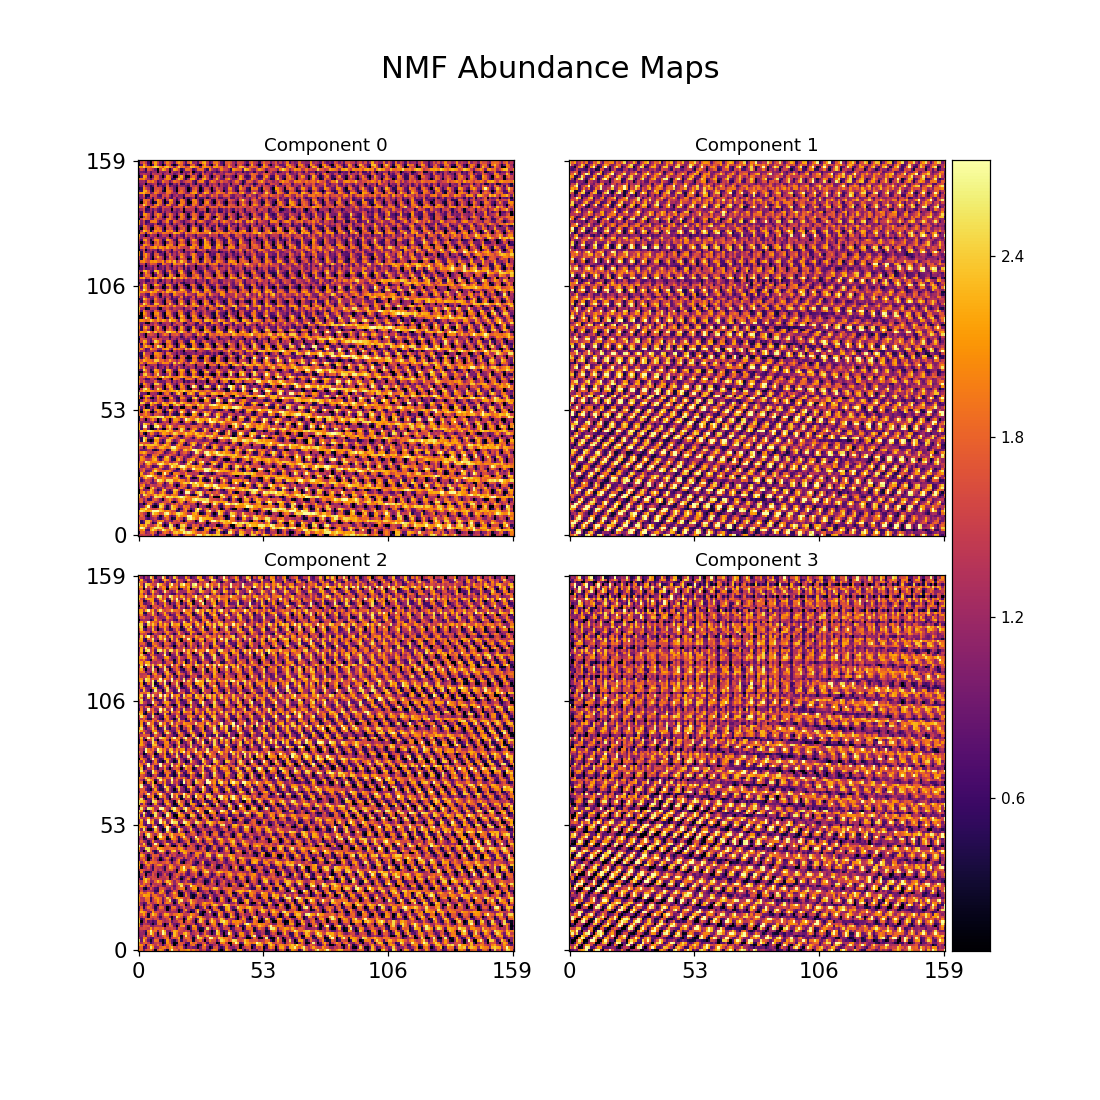

<IPython.core.display.Javascript object>


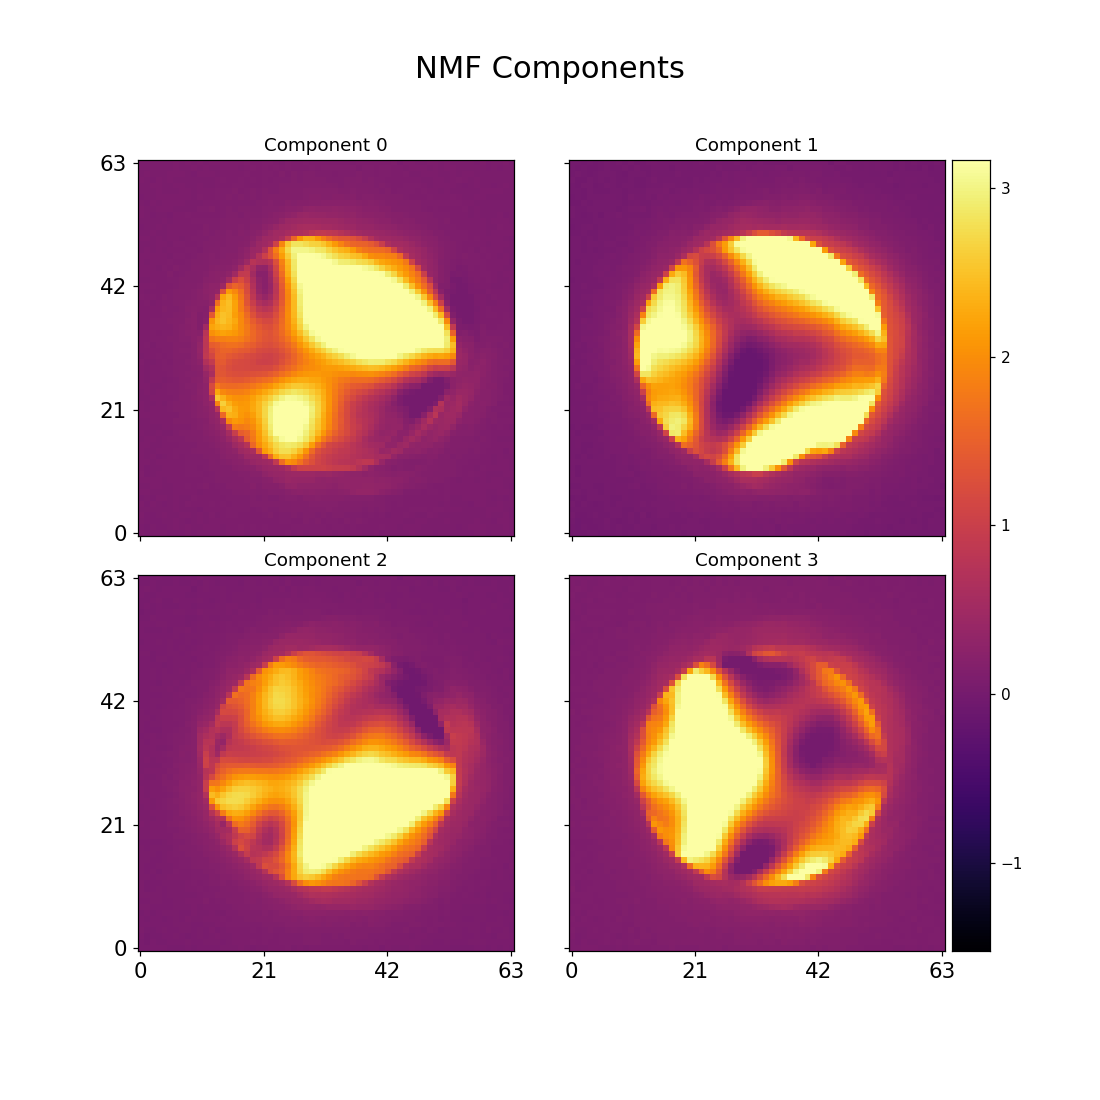

In [12]:
num_comps = 4

#Choose the NMFmodel from sklearn
nmf_model = NMF(n_components=num_comps, init='random', random_state=0)

#pycroscopy can handle this decomposition given an sklearn estimator object
decomposer = px.processing.decomposition.Decomposition(h5_main, estimator =nmf_model)
h5_nmf_group = decomposer.compute() #compute it. Saves results into the file and returns reference to it.

components = h5_nmf_group['Components'] #Components 
projection  = h5_nmf_group['Projection'] #Coefficients/scores

nmf_coeffs_fig = usid.plot_utils.plot_map_stack(projection[:].reshape(num_rows,num_cols,-1), num_comps=num_comps, title='NMF Abundance Maps', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95, clim = [0,2.5])

nmf_components_fig = usid.plot_utils.plot_map_stack(components[:].reshape(-1, h5_main.n_dim_sizes[-2],h5_main.n_dim_sizes[-1]).transpose(1,2,0), num_comps=num_comps, 
                                                    title='NMF Components', reverse_dims=True,
                             color_bar_mode='single', cmap='inferno', title_yoffset=0.95, clim = [0,3])

## Clustering
Clustering divides data into k clusters such that the variance within each cluster is minimized. 

In principle, clustering can be perfomed on any dataset that has some spectral values (eg. - ronchgirams in the case of the raw dataset or an array of values for each SVD component) for each position. However, the computation time increases with the size of the dataset.

Here, we will be performing k-means clustering on the U matrix from SVD. 
We want a large enough number of clusters so that K-means identifies fine nuances in the data. At the same time, we want to minimize computational time by reducing the number of clusters. We recommend 32 clusters.

In [13]:
# Choose how many SVD components to use in clustering
spectral_components = 128
# Choose how many clusters to use
num_clusters = 32  ##############################################

In [14]:
estimator = KMeans(n_clusters=num_clusters)

proc = px.processing.Cluster(h5_u, estimator, num_comps=spectral_components)

h5_kmeans_group = proc.compute()
    
h5_labels = h5_kmeans_group['Labels']
h5_centroids = h5_kmeans_group['Mean_Response']

# In case we take existing results, we need to get these parameters
num_comps_for_clustering = h5_centroids.shape[1]

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes back to the HDF5 file
Note: Cluster has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation
[<HDF5 group "/Measurement_000/Channel_000/Raw_Data-SVD_004/U-Cluster_002" (8 members)>]
Returning previously computed results from: /Measurement_000/Channel_000/Raw_Data-SVD_004/U-Cluster_002
set the "override" flag to True to recompute results


C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')
C:\Users\sjz\AppData\Local\Continuum\Anaconda3\lib\site-packages\pyUSID\io\hdf_utils.py:722: UserWarning: units attribute was missing
  warn('units attribute was missing')


#### Visualize k-means results

<IPython.core.display.Javascript object>


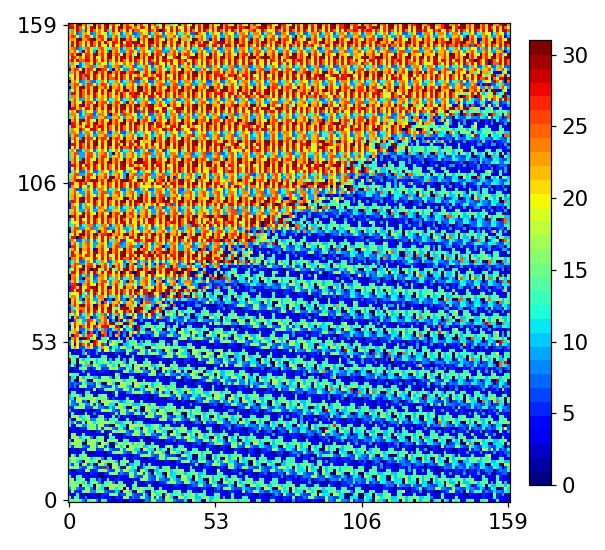

In [15]:
label_mat = np.reshape(h5_labels, (num_rows, num_cols))
fig, axes = px.viz.cluster_utils.plot_cluster_labels(label_mat, num_clusters=num_clusters, cmap = plt.cm.jet)

#### Visualize the hierarchical clustering
The vertical length of the branches indicates the relative separation between neighboring clusters.

Creating full dendrogram from clusters


<IPython.core.display.Javascript object>


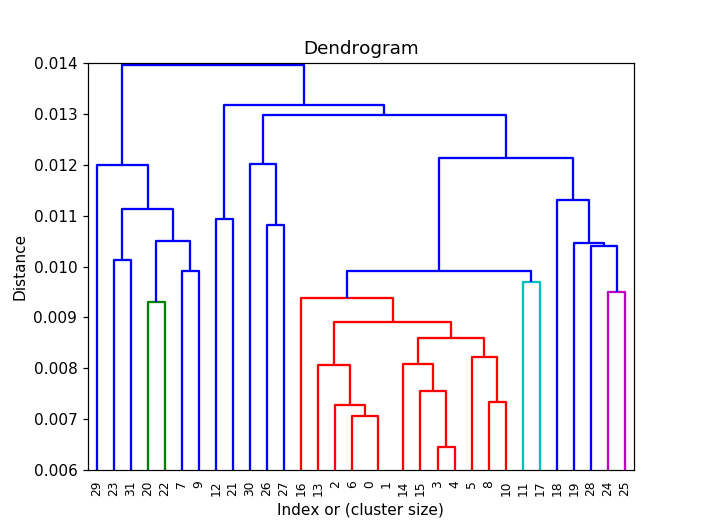

(0.006, 0.014)

In [16]:
e_vals = np.reshape(h5_u[:, :spectral_components], 
                    (num_rows, num_cols, -1))
fig = px.viz.cluster_utils.plot_cluster_dendrogram(label_mat, e_vals, 
                                                   num_comps_for_clustering, 
                                                   num_clusters, 
                                                   last=num_clusters);
fig.axes[0].set_ylim([0.006,.014])

### Save and close
* Save the .h5 file that we are working on by closing it. <br>
* Also, consider exporting this notebook as a notebook or an html file. <br> To do this, go to File >> Download as >> HTML
* Finally consider saving this notebook if necessary

In [17]:
h5_file.close()